In [1]:
# load JSON
import json
import pandas as pd
import numpy as np

SMAPE_arr = []
nSampleArr = [5000,10000,15000,20000,25000,30000,35000,40000,45000]

for i in nSampleArr:
    
    print(i)
    n_samples = i
    
    # hourly data 
    data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
    data = data.sort_values(by=['ds'])
    data['just_date'] = data['ds'].dt.date
    temp = data.iloc[-1,:]
    firstDate = temp['just_date']

    t_start = len(data) - n_samples
    df_h = data[t_start:(t_start+n_samples)]

    import matplotlib.pyplot as plt
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    plt.figure(figsize=(15,3))
    plt.plot(df_h['ds'],df_h['y'])
    plt.title('by hour')

    df = df_h # select daily or hourly daya
    n_prd = 336

    from fbprophet import Prophet

    m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
    m.fit(df)
    future = m.make_future_dataframe(periods=n_prd, freq='H')
    forecast = m.predict(future)
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    fig = m.plot(forecast)
    components_fig = m.plot_components(forecast)

    from fbprophet.plot import add_changepoints_to_plot
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)

    # PROPHET validation
    from fbprophet.diagnostics import cross_validation
    horInt = int(365*i/50000)
    df_cv = cross_validation(m, horizon = str(horInt) + ' days') # horizon: forecast ; initial: training (default: 3x horizon); 
    df_cv.head()

    # Performance metrics
    from fbprophet.diagnostics import performance_metrics
    df_p = performance_metrics(df_cv)
    df_p.head()

    # mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
    # computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
    # By default, 10% of the predictions in each window (can be changed) 
    # high rollingwindow --> smoother average curve 

    # Visualize cross-validation
    from fbprophet.plot import plot_cross_validation_metric
    fig = plot_cross_validation_metric(df_cv, metric='mape')

    # Percentage errors
    mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
    smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
    print('MAPE = ' + str(mape) + '%')
    print('SMAPE = ' + str(smape) + '%')
    SMAPE_arr.append(smape)

5000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-07-01 19:00:00 and 2019-08-24 19:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE = 164.55174437100916%
SMAPE = 16.373516664976982%
10000


INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-03-31 07:00:00 and 2019-07-18 19:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE = 87.57410615851617%
SMAPE = 15.719684311746171%
15000


INFO:fbprophet:Making 4 forecasts with cutoffs between 2018-12-31 07:00:00 and 2019-06-12 19:00:00


MAPE = 76.7609716914073%
SMAPE = 15.86214989569724%
20000


INFO:fbprophet:Making 4 forecasts with cutoffs between 2018-09-29 19:00:00 and 2019-05-06 19:00:00


MAPE = 347.86031740708574%
SMAPE = 31.42764857564813%
25000


/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

MAPE = 463.97334645733963%
SMAPE = 30.92083567678546%
30000


/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

MAPE = 252.97906489464106%
SMAPE = 26.024153701193807%
35000


/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

MAPE = 140.3498976879983%
SMAPE = 26.13924119454204%
40000


/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

MAPE = 353.6980378485478%
SMAPE = 31.483085441655838%
45000


/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/aety/anaconda3/envs/insight/lib/python3.7/site-packages/fbprophet/plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

MAPE = 123.55446914047332%
SMAPE = 25.276699347639937%


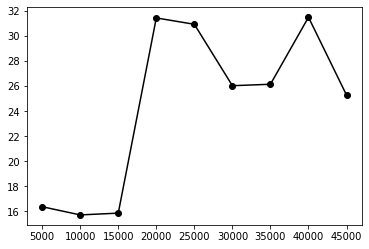

In [5]:
plt.plot(nSampleArr,SMAPE_arr,'o-k')

In [ ]:
# old optimization results (by 09/25/2019)
5000,  16.13646602812886
10000, 15.13057036820503
15000, 17.72657811508373
20000, 36.62962013304121
25000, 29.003435928351603
30000, 21.26478744416783
35000, 30.148436561689696
40000, 31.061258629527774
45000, 23.74076241645964
50000, 17.678008279889458

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


10000


INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-03-31 07:00:00 and 2019-07-18 19:00:00


MAPE = 87.57410615851617%
SMAPE = 15.719684311746171%
*** Data Saved ***


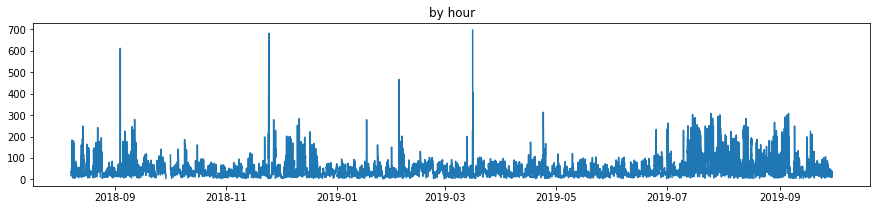

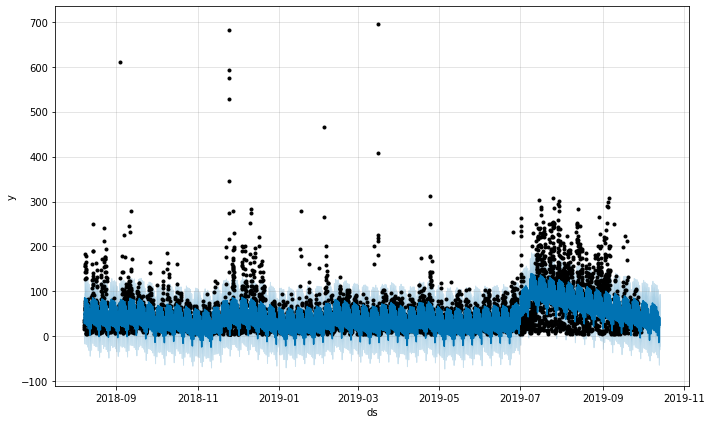

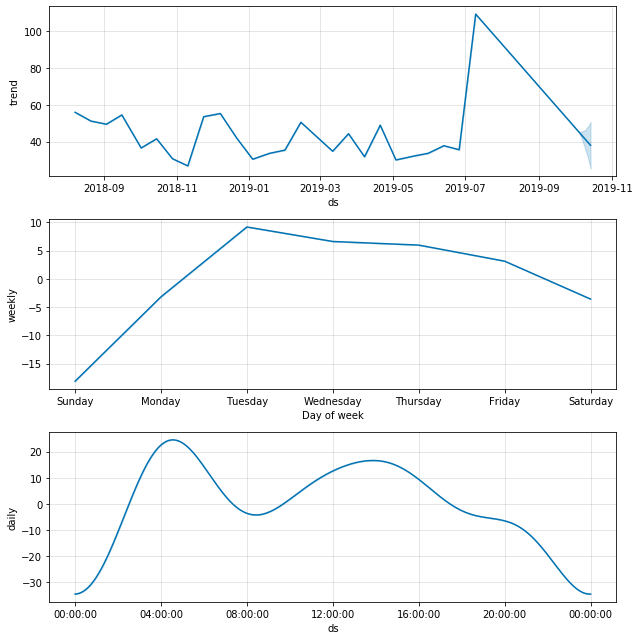

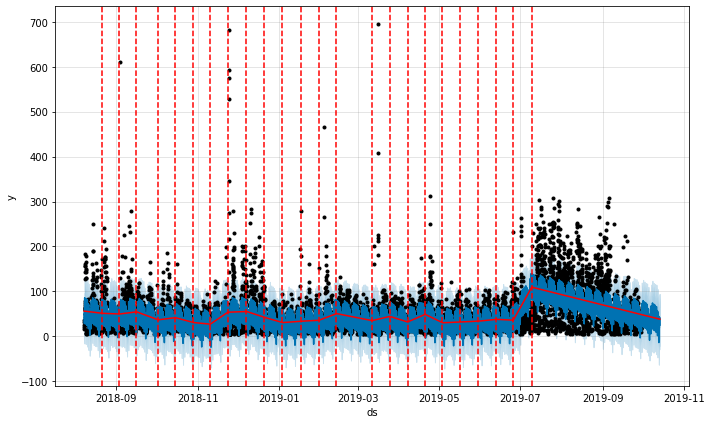

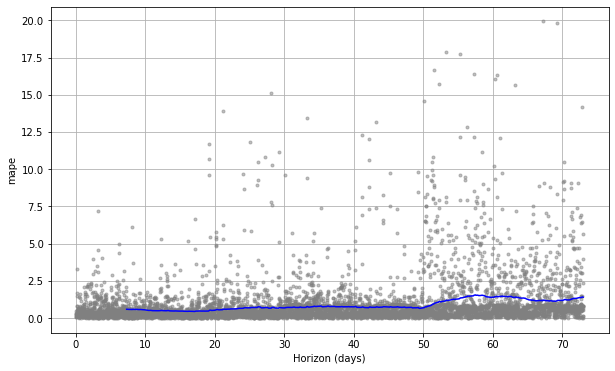

In [6]:
# load JSON
import json
import pandas as pd
import numpy as np

SMAPE_arr = []
nSampleArr = [10000]

for i in nSampleArr:
    
    print(i)
    n_samples = i
    
    # hourly data 
    data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
    data = data.sort_values(by=['ds'])
    data['just_date'] = data['ds'].dt.date
    temp = data.iloc[-1,:]
    firstDate = temp['just_date']

    t_start = len(data) - n_samples
    df_h = data[t_start:(t_start+n_samples)]

    import matplotlib.pyplot as plt
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    plt.figure(figsize=(15,3))
    plt.plot(df_h['ds'],df_h['y'])
    plt.title('by hour')

    df = df_h # select daily or hourly daya
    n_prd = 336

    from fbprophet import Prophet

    m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
    m.fit(df)
    future = m.make_future_dataframe(periods=n_prd, freq='H')
    forecast = m.predict(future)
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    fig = m.plot(forecast)
    components_fig = m.plot_components(forecast)

    from fbprophet.plot import add_changepoints_to_plot
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)

    # PROPHET validation
    from fbprophet.diagnostics import cross_validation
    horInt = int(365*i/50000)
    df_cv = cross_validation(m, horizon = str(horInt) + ' days') # horizon: forecast ; initial: training (default: 3x horizon); 
    df_cv.head()

    # Performance metrics
    from fbprophet.diagnostics import performance_metrics
    df_p = performance_metrics(df_cv)
    df_p.head()

    # mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
    # computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
    # By default, 10% of the predictions in each window (can be changed) 
    # high rollingwindow --> smoother average curve 

    # Visualize cross-validation
    from fbprophet.plot import plot_cross_validation_metric
    fig = plot_cross_validation_metric(df_cv, metric='mape')

    # Percentage errors
    mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
    smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
    print('MAPE = ' + str(mape) + '%')
    print('SMAPE = ' + str(smape) + '%')
    SMAPE_arr.append(smape)
    
import pickle
pkl_path = "franklin-d-roosevelt/PM10_hourly_m.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("franklin-d-roosevelt/PM10_hourly_forecast.pkl")
print("*** Data Saved ***")